In [48]:
import sys, os
import importlib
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn

In [90]:
SRC_DIR = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
if SRC_DIR not in sys.path:
    sys.path.append(SRC_DIR)
PARENT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PARENT_DIR)
conf = importlib.import_module('confs.iiwa_conf')
env = getattr(conf, 'IiwaEnv')(conf)


from neural_network import ActorCriticNet
from rl_trainer import RLTrainer
from opt.traj_opt import TrajOpt

ac_net = ActorCriticNet(env, conf)
actor = ac_net.create_actor()
critic = ac_net.create_critic_sine()
TO = TrajOpt(env, conf)

# Load the weights
actor_path = '/home/seyoungree/Documents/GATO-RL/iiwa/2025-07-23_14-24/actor_final.pth'
critic_path = '/home/seyoungree/Documents/GATO-RL/iiwa/2025-07-23_14-24/critic_final.pth'
actor.load_state_dict(torch.load(actor_path, map_location='cpu'))
critic.load_state_dict(torch.load(critic_path, map_location='cpu'))
actor.eval()
critic.eval()

Sequential(
  (0): Siren(
    (activation): Sine()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (1): Siren(
    (activation): Sine()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (2): Siren(
    (activation): Sine()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (3): Siren(
    (activation): Sine()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (4): Linear(in_features=128, out_features=1, bias=True)
)

In [91]:
%matplotlib inline

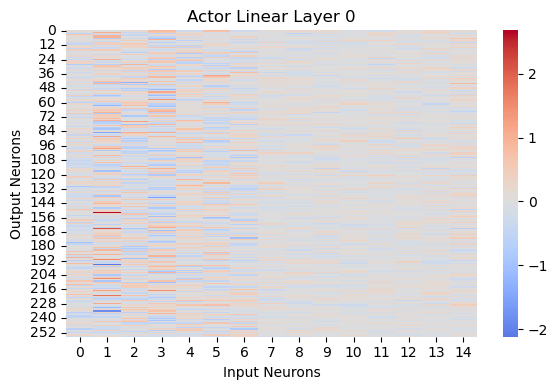

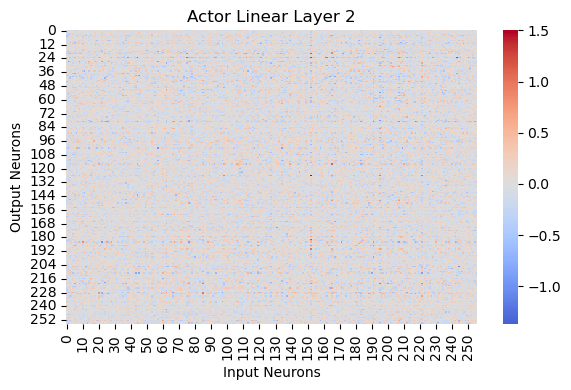

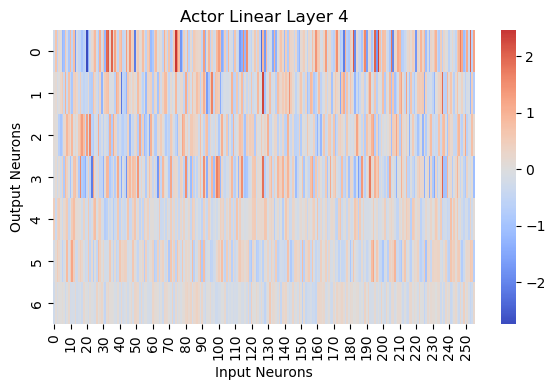

In [92]:
def visualize_weights(weights, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(weights, cmap='coolwarm', center=0)
    plt.title(title)
    plt.xlabel("Input Neurons")
    plt.ylabel("Output Neurons")
    plt.tight_layout()
    plt.show()

def visualize_model_weights(model, name="Model"):
    for i, layer in enumerate(model):
        # Standard linear layer
        if isinstance(layer, nn.Linear):
            w = layer.weight.detach().cpu().numpy()
            visualize_weights(w, f"{name} Linear Layer {i}")
        
        elif hasattr(layer, "linear") and isinstance(layer.linear, nn.Linear):
            w = layer.linear.weight.detach().cpu().numpy()
            visualize_weights(w, f"{name} Siren Layer {i}")
# Visualize
visualize_model_weights(actor, "Actor")

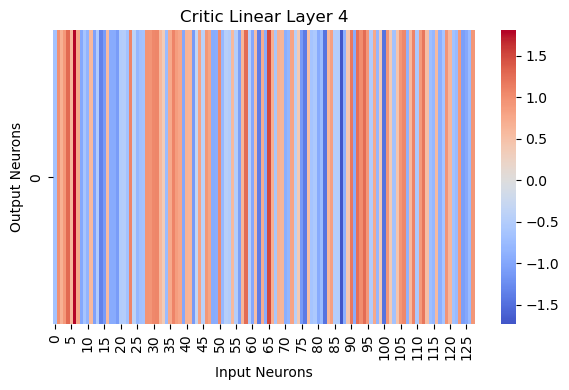

In [93]:
visualize_model_weights(critic, "Critic")

   t |       q0 |       q1 |       q2 |       q3 |       q4 |       q5 |       q6 |       v0 |       v1 |       v2 |       v3 |       v4 |       v5 |       v6 | u 0 | u 1 | u 2 | u 3 | u 4 | u 5 | u 6
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
   0 |    0.000 |    0.000 |    0.000 |    0.000 |    0.000 |    0.000 |    0.000 |    0.000 |    0.000 |    0.000 |    0.000 |    0.000 |    0.000 |    0.000 |   -7.936 |  -15.683 |    2.183 |  -52.239 |    4.237 |    6.956 |    4.090
   1 |   -0.013 |   -0.012 |    0.017 |   -0.031 |    0.006 |   -0.003 |    0.072 |   -1.341 |   -1.191 |    1.702 |   -3.146 |    0.612 |   -0.312 |    7.207 |   11.513 |   -9.071 |    7.373 |   -0.457 |    5.653 |   -1.718 |    0.649
   2 |   -0.021 |   -0.026 |    0.033 |   -0.068 |    0.050 |   -0.018 |    0.114 |   -0.757 |   -1.394 |    1.641 |   -3.621 

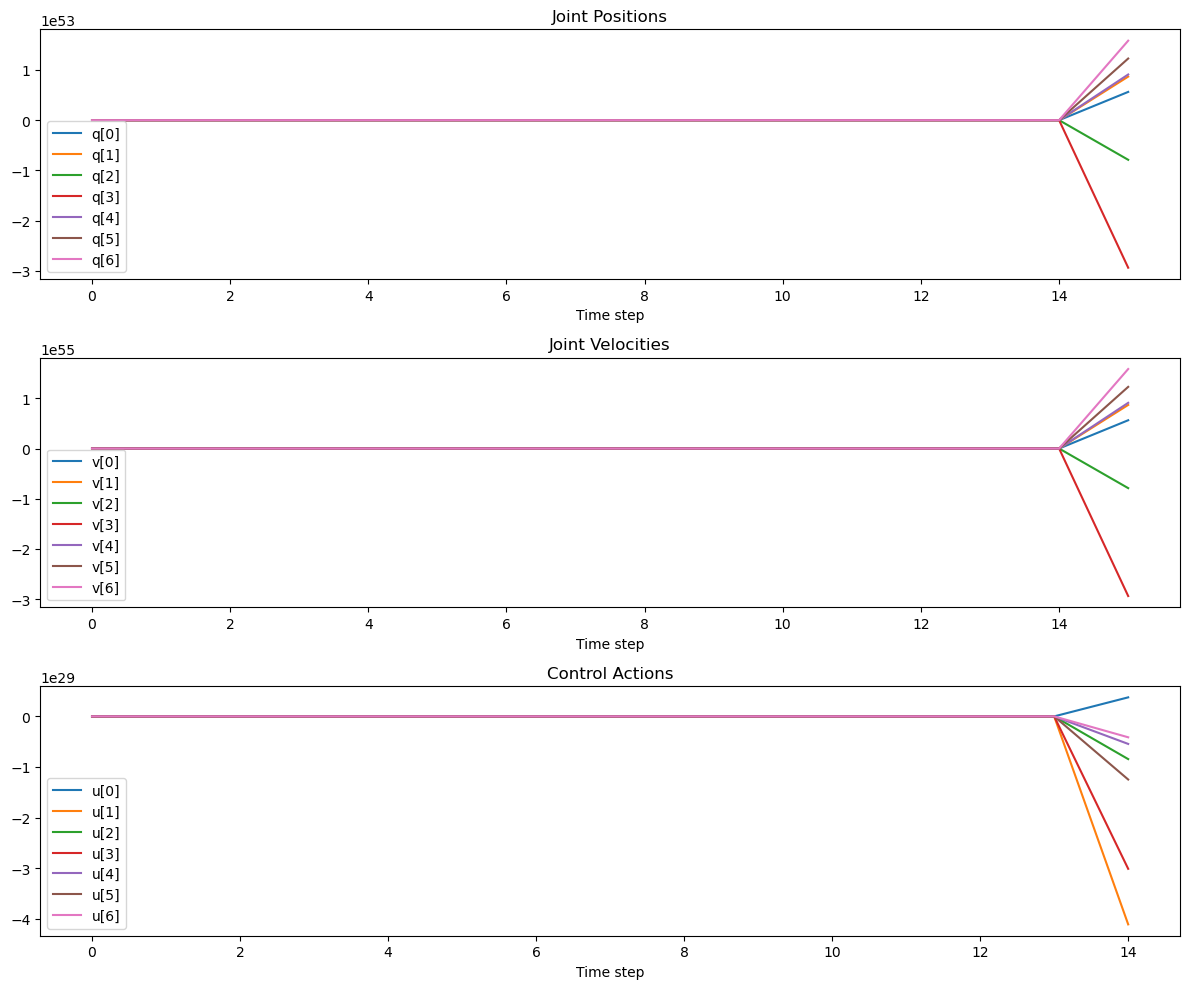

In [94]:
# Test the actor with a single trajectory rollout from an initial state for IIWA
T = 0.0
steps = conf.NSTEPS - int(T / conf.dt)

# Initialize state: 7 joint positions + 7 joint velocities + time
init_q = np.zeros(7)         # Example joint positions
init_v = np.zeros(7)         # Example joint velocities
init_state = np.concatenate([init_q, init_v, [T]])  # (15,)

states = np.zeros((steps + 1, conf.nx + 1))  # (steps + 1, 15)
states[0] = init_state
actions = np.zeros((steps, conf.nu))        # (steps, 7)

# Header
joint_labels = [f"q{i}" for i in range(7)] + [f"v{i}" for i in range(7)]
header = f"{'t':>4} | " + " | ".join([f"{l:>8}" for l in joint_labels]) + " | " + " | ".join([f"u{i:>2}" for i in range(7)])
print(header)
print("-" * len(header))

# Rollout
for t in range(steps):
    state_tensor = torch.tensor(states[t][None], dtype=torch.float32)
    with torch.no_grad():
        action = ac_net.eval(actor, state_tensor, is_actor=True).cpu().numpy().squeeze()
    actions[t] = action
    q_vals = states[t, :7]
    v_vals = states[t, 7:14]
    line = f"{t:4d} | " + " | ".join(f"{x:8.3f}" for x in np.concatenate([q_vals, v_vals, action]))
    print(line)
    states[t + 1, :] = env.simulate(states[t, :-1], actions[t])

# Plot all joints
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(12, 10))

# Plot joint positions
for i in range(7):
    axs[0].plot(states[:, i], label=f'q[{i}]')
axs[0].set_title('Joint Positions')
axs[0].set_xlabel('Time step')
axs[0].legend()

# Plot joint velocities
for i in range(7):
    axs[1].plot(states[:, 7 + i], label=f'v[{i}]')
axs[1].set_title('Joint Velocities')
axs[1].set_xlabel('Time step')
axs[1].legend()

# Plot actions
for i in range(7):
    axs[2].plot(actions[:, i], label=f'u[{i}]')
axs[2].set_title('Control Actions')
axs[2].set_xlabel('Time step')
axs[2].legend()

plt.tight_layout()
plt.show()
